In [1]:
import sys
import pathlib
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from copairs import map
from pycytominer import normalize

# import repo based utils
sys.path.append("../../../")
from utils import data_utils, io_utils


/home/erikserrano/Programs/miniconda3/envs/cfret-map/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def rename_map_columns(map_df, prefix):
    """Renames mAP score columns with a specified prefix (negative or positive).

    Parameters
    ----------
    map_df : pandas.DataFrame
        DataFrame containing mAP scores.
    prefix : str
        Prefix to add to the column names (e.g., 'negative' or 'positive').

    Returns
    -------
    pandas.DataFrame
        DataFrame with renamed columns.
    """
    return map_df.rename(
        columns={
            "mean_average_precision": f"{prefix}_mean_average_precision",
            "corrected_p_value": f"{prefix}_corrected_p_value",
        }
    )


def calculate_delta_map(map_df):
    """Calculates delta mAP as the difference between negative and positive mean average precision.

    Parameters
    ----------
    map_df : pandas.DataFrame
        DataFrame containing mAP scores with 'negative_mean_average_precision' and
        'positive_mean_average_precision' columns.

    Returns
    -------
    pandas.DataFrame
        DataFrame with an additional 'delta_mAP' column.
    """
    map_df["delta_mAP"] = (
        map_df["negative_mean_average_precision"]
        - map_df["positive_mean_average_precision"]
    )
    return map_df


def add_pathway_info(map_df, pathway_df):
    """Merges pathway information into the dataframe and removes the 'UCD ID' column.

    Parameters
    ----------
    map_df : pandas.DataFrame
        DataFrame containing mAP scores.
    pathway_df : pandas.DataFrame
        DataFrame containing pathway information with 'UCD ID' and 'Pathway' columns.

    Returns
    -------
    pandas.DataFrame
        DataFrame with merged pathway information.
    """
    return map_df.merge(
        pathway_df, left_on="Metadata_treatment", right_on="UCD ID", how="inner"
    ).drop(columns="UCD ID")


def filter_ref_control(map_df, ref_type, control_type, value_column):
    """Filters dataframe based on reference and control type, selecting relevant columns.

    Parameters
    ----------
    map_df : pandas.DataFrame
        DataFrame containing mAP scores.
    ref_type : str
        Type of reference control (e.g., 'positive' or 'negative').
    control_type : str
        Type of control (e.g., 'positive' or 'negative').
    value_column : str
        Name of the column containing the mAP scores to be selected.

    Returns
    -------
    pandas.DataFrame
        Filtered DataFrame containing only the relevant columns.
    """
    return map_df.loc[
        (map_df["Metadata_reference_control_type"] == ref_type)
        & (map_df["Metadata_control_type"] == control_type),
        ["Metadata_plate_barcode", "Metadata_control_type", value_column],
    ]


def add_control_type(profile: pd.DataFrame) -> pd.DataFrame:
    """Add control type metadata to the dataframe based on cell type.

    Parameters
    ----------
    profile : pandas.DataFrame
        DataFrame containing the profiles with 'Metadata_cell_type' column.

    Returns
    -------
    pandas.DataFrame
        DataFrame with an additional 'Metadata_control_type' column.
    """
    profile.insert(2, "Metadata_control_type", np.nan)
    profile.loc[profile["Metadata_cell_type"] == "healthy", "Metadata_control_type"] = (
        "positive"
    )
    profile.loc[profile["Metadata_cell_type"] == "failing", "Metadata_control_type"] = (
        "negative"
    )
    return profile


In [3]:
# setting in input paths
data_dir_path = pathlib.Path("../../data")

# selecting aggregated feature selected files
list_of_paths = list(
    (data_dir_path / "agg_fs_profiles/").resolve(strict=True).glob("*.parquet")
)

# shared features columns
shared_features_path = pathlib.Path(
    "../../1.map-analysis/results/shared_features.json"
).resolve(strict=True)

# set configs path
config_path = pathlib.Path("../../config.yaml").resolve(strict=True)

# creating a results output directory
results_dir = pathlib.Path("./results").resolve()
results_dir.mkdir(exist_ok=True)

Here we are loading in the aggregate feature selected profiles and only selected the DMSO profiles

In [4]:
# loading config
config = io_utils.load_config(config_path)

# loading shared features
shared_features = io_utils.load_config(shared_features_path)["shared_features"]

# loading all feature selected aggregated profiles and updating it with the shared features
loaded_aggregated_profiles = []
loaded_shuffled_profiles = []
for plate_idx, profile_path in enumerate(list_of_paths):
    # getting the plate name
    plate_name = profile_path.stem.split("_")[0]

    # loading aggregated profiles
    aggregated_profiles = pd.read_parquet(profile_path)

    # updating the profile with the shared features
    aggregated_profiles = aggregated_profiles[shared_features]

    # inserting the plate name at the first column
    aggregated_profiles.insert(0, "Metadata_plate_barcode", plate_name)
    aggregated_profiles.insert(1, "Metadata_plate_index", plate_idx + 1)

    # next is to shuffled the data
    shuffled_aggregated_profiles = data_utils.shuffle_features(aggregated_profiles)

    # append it to the list
    loaded_aggregated_profiles.append(aggregated_profiles)
    loaded_shuffled_profiles.append(shuffled_aggregated_profiles)

# concatenating all the profiles
loaded_aggregated_profiles = pd.concat(loaded_aggregated_profiles).reset_index(
    drop=True
)
shuffled_aggregated_profiles = pd.concat(loaded_shuffled_profiles).reset_index(
    drop=True
)

# add metadata into the dmso profile where if Metadata_cell_type == "healthy" then Metadata_control_type == "positive"
# add if Metadata_cell_type == "failing" then Metadata_control_type == "negative"
# Apply to both aggregated and shuffled profiles
loaded_aggregated_profiles = add_control_type(loaded_aggregated_profiles)
shuffled_aggregated_profiles = add_control_type(shuffled_aggregated_profiles)

# split metadata and morphology feature columns
meta_cols, feat_cols = data_utils.split_meta_and_features(loaded_aggregated_profiles)

# store aggregate data profiles as batched
loaded_profiles = {"batch_1": loaded_aggregated_profiles}
shuffled_loaded_profiles = {"batch_1": shuffled_aggregated_profiles}

# display only not shuffled aggregated profiles dmso profiles
print(loaded_profiles["batch_1"].shape)
loaded_profiles["batch_1"].head()

(220, 485)


/tmp/ipykernel_42371/1239585453.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'positive' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  profile.loc[profile["Metadata_cell_type"] == "healthy", "Metadata_control_type"] = (
/tmp/ipykernel_42371/1239585453.py:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  profile.insert(2, "Metadata_control_type", np.nan)
/tmp/ipykernel_42371/1239585453.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'positive' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  profi

,Metadata_plate_barcode,Metadata_plate_index,Metadata_control_type,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Pathway,...,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_01_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_02_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_03_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_00_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumEntropy_PM_3_01_256
0,localhost240927060001,1,positive,B,2,7,healthy,None,DMSO,None,...,0.340226,-0.397719,-0.554410,-0.597032,-0.599841,-0.452233,-0.512690,-0.479060,-0.487456,0.377711
1,localhost240927060001,1,negative,B,3,19,failing,dilated_cardiomyopathy,UCD-0159256,Apoptosis,...,0.426732,0.192443,0.201591,0.193599,0.207943,-0.591082,-0.595971,-0.438921,-0.572451,0.509203
2,localhost240927060001,1,negative,B,4,19,failing,dilated_cardiomyopathy,UCD-0001766,Angiogenesis,...,0.970090,-0.780760,-0.846263,-0.654640,-0.655297,-1.282220,-1.381008,-1.344134,-1.241213,1.432368
3,localhost240927060001,1,positive,B,5,7,healthy,None,DMSO,None,...,0.218604,-0.125840,-0.107253,-0.217232,-0.302984,-0.218122,-0.285449,-0.181189,-0.307638,0.227360
4,localhost240927060001,1,negative,B,6,19,failing,dilated_cardiomyopathy,UCD-0159262,Others,...,1.039161,-1.043130,-1.173101,-1.073500,-0.994948,-1.680824,-1.553425,-1.727551,-1.443283,1.551807


## Executing spherization parameter search 

In [5]:
# Setting the parameter grid for spherization
# method: applying spherize transformation method 
# spherize_center: True, False, which is the centering of the data
# spherize_method: PCA, ZCA, PCA-cor, ZCA-cor, which is the method to use for spherization
# spherize_epsilon: 1e-10 to 1e2, which is the epsilon value to use for spherization
spherization_param_grid = {
    "method": ["spherize"],
    "spherize_center": [True, False],
    "spherize_method": ["PCA", "ZCA", "PCA-cor", "ZCA-cor"],
    "spherize_epsilon": np.logspace(-10, 2, num=20).tolist(),
}

# Generate all possible combinations of the spherization parameters
# this will allow us to test different spherization methods and parameters and see how
# it affects the mAP scores
param_combinations = list(itertools.product(*spherization_param_grid.values()))

In [6]:
# setting controls labels
control_list = ["negative", "positive"]

# setting configs
general_configs = config["general_configs"]
cntrl_copairs_ap_configs = config["dmso_copairs_ap_configs"]
cntrl_copairs_map_configs = config["dmso_copairs_map_configs"]

# conducting the spherization and mAP calculation parameter grid search
mAP_scores = []
mmAP_scores_df = []

# iterate over the spherization parameters
for method, spherize_center, spherize_method, spherize_epsilon in param_combinations:

    # loading profiles from each batch
    for batch_id, profile_df in loaded_profiles.items():

        # split features of original aggregated profile to metadata and features column names
        meta_cols, feat_cols = data_utils.split_meta_and_features(profile_df)

        # now iterating over the control types by declaring it our reference control
        for ref_type in control_list:

            # apply spherization using the reference type for the samples parameter
            # this indicates that we are only applying spherization to the samples that match the reference control type
            try:
                spherized_profile = normalize(
                    profiles=profile_df,
                    features=feat_cols,
                    meta_features=meta_cols,
                    samples=f"Metadata_control_type == '{ref_type}'",
                    method=method,
                    spherize_center=spherize_center,
                    spherize_method=spherize_method,
                    spherize_epsilon=spherize_epsilon,
                )

            # This is to catch any errors that may occur during spherization hyperparameter search
            # due to the fact that some hyperparameters may not be compatible with the spherization method
            except ValueError as e:
                print(f"Error: {e}, skipping step")
                continue

            # Now that we have the spherized profiles, next is to only extract profiles (well level data)
            # that have been treated with DMSO
            dmso_profile = spherized_profile.query("Metadata_treatment == 'DMSO'")

            # get the unique plate ids
            plate_ids = dmso_profile.Metadata_plate_barcode.unique().tolist()

            # add both a treatments and control type tags to the DMSO profiles
            # control type indicates weather they are failing or healthy cells:
            # failing = negative control (Failing CF cells + DMSO)
            # healthy = positive control (Healthy CF cells + DMSO)
            dmso_profile["Metadata_treatment_type"] = (
                "control"  # Tag all rows as control
            )
            dmso_profile["Metadata_control_type"] = dmso_profile.apply(
                lambda row: data_utils.label_control_types(
                    row["Metadata_cell_type"], row["Metadata_heart_failure_type"]
                ),
                axis=1,
            )

            # Reset index and store the original index for reference and ensure it is an integer
            dmso_profile = dmso_profile.reset_index().rename(
                columns={"index": "Metadata_original_index"}
            )
            dmso_profile["Metadata_original_index"] = dmso_profile[
                "Metadata_original_index"
            ].astype(int)

            # Now that we have the DMSO profiles prepared, next is to calculate the mAP scores
            # initialize list to store mAP scores for each targeted plate
            ap_scores = []

            # iterate each plate id to become the targeted plate
            for targeted_plate_id in plate_ids:

                # Create a deep copy of the DMSO profile for manipulation
                dmso_profile_w_target_plate = dmso_profile #.copy(deep=True)

                # update the profiles by indicating which wells belong to the targeted plate
                dmso_profile_w_target_plate["Metadata_targeted"] = (
                    dmso_profile_w_target_plate["Metadata_plate_barcode"].apply(
                        lambda plate_id: plate_id == targeted_plate_id
                    )
                )

                # Metadata indicating the reference index for each well:
                # - all wells that are in the targeted plate should have the reference index (e.g 1,2,3,4)
                # - all well that are not in the targeted plate should have -1, there are the reference wells (e.g -1, -1, -1)
                # This allows us to have control on how to compare the control wells for AP calculation 
                dmso_profile_w_target_plate["Metadata_reference_index"] = (
                    dmso_profile_w_target_plate.index
                )
                dmso_profile_w_target_plate["Metadata_reference_index"] = (
                    dmso_profile_w_target_plate.apply(
                        lambda row: row["Metadata_reference_index"]
                        if row["Metadata_targeted"]
                        and row["Metadata_control_type"] == ref_type
                        else -1,
                        axis=1,
                    )
                )

                # adding metadata indicating what is the reference control type when comparing with the targeted control
                dmso_profile_w_target_plate["Metadata_reference_control_type"] = (
                    ref_type
                )

                # splitting the metadata and feature columns of the spherized dmso profile
                dmso_meta = [
                    cols
                    for cols in dmso_profile_w_target_plate.columns.tolist()
                    if cols.startswith("Metadata_")
                ]
                dmso_feats = [
                    cols
                    for cols in dmso_profile_w_target_plate.columns.tolist()
                    if not cols.startswith("Metadata_")
                ]

                # compute average precision (AP) scores for the current setup
                dmso_ap_scores = map.average_precision(
                    meta=dmso_profile_w_target_plate[dmso_meta],
                    feats=dmso_profile_w_target_plate[dmso_feats].values,
                    pos_sameby=cntrl_copairs_ap_configs["pos_sameby"],
                    pos_diffby=[],
                    neg_sameby=[],
                    neg_diffby=cntrl_copairs_ap_configs["neg_diffby"],
                    batch_size=cntrl_copairs_ap_configs["batch_size"],
                    distance=cntrl_copairs_ap_configs["distance"],
                )

                ap_scores.append(dmso_ap_scores)

            # concatenate the AP scores
            dmso_ap_scores = pd.concat(ap_scores)

            # calculate mean Average Precision (mAP) scores
            dmso_map_scores = map.mean_average_precision(
                dmso_ap_scores,
                sameby=cntrl_copairs_map_configs["same_by"],
                null_size=cntrl_copairs_map_configs["null_size"],
                threshold=cntrl_copairs_map_configs["threshold"],
                seed=general_configs["seed"],
            )

            # now calculate the mmAP scores by taking the mean of the mAP scores
            for name, mAP_df in dmso_map_scores.groupby(
                by=[
                    "Metadata_plate_barcode",
                    "Metadata_reference_control_type",
                    "Metadata_control_type",
                ]
            ):
                # calculate the mean of the mAP scores
                mmAP = mAP_df["mean_average_precision"].mean()

                # adding the mmAP scores to the list including spherization parameters
                mmAP_scores_df.append(
                    [
                        name[0],
                        name[1],
                        name[2],
                        method,
                        spherize_center,
                        spherize_method,
                        spherize_epsilon,
                        mmAP,
                    ]
                )

# 
mmAP_scores_df = pd.DataFrame(
    mmAP_scores_df,
    columns=[
        "Metadata_plate_barcode",
        "Metadata_reference_control_type",
        "Metadata_control_type",
        "method",
        "spherize_center",
        "spherize_method",
        "spherize_epsilon",
        "mmAP",
    ],
)

mmAP_scores_df

Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: PCA-cor and ZCA-cor require center=True, skipping step
Error: P

,Metadata_plate_barcode,Metadata_reference_control_type,Metadata_control_type,method,spherize_center,spherize_method,spherize_epsilon,mmAP
0,localhost240926150001,negative,negative,spherize,True,PCA,1.000000e-10,0.837435
1,localhost240926150001,negative,positive,spherize,True,PCA,1.000000e-10,0.965587
2,localhost240927060001,negative,negative,spherize,True,PCA,1.000000e-10,0.820601
3,localhost240927060001,negative,positive,spherize,True,PCA,1.000000e-10,0.965361
4,localhost240927120001,negative,negative,spherize,True,PCA,1.000000e-10,0.785259
...,...,...,...,...,...,...,...,...
1915,localhost240927060001,positive,positive,spherize,False,ZCA,1.000000e+02,0.684389
1916,localhost240927120001,positive,negative,spherize,False,ZCA,1.000000e+02,0.961935
1917,localhost240927120001,positive,positive,spherize,False,ZCA,1.000000e+02,0.701360
1918,localhost240928120001,positive,negative,spherize,False,ZCA,1.000000e+02,0.956639


In [7]:
# concatenate the mmAP scores for positive and negative control types
mmAP_concat_df = pd.concat(
    [
        # mmAP scores when comparing positive target and references 
        mmAP_scores_df.loc[
            (mmAP_scores_df["Metadata_reference_control_type"] == "positive")
            & (mmAP_scores_df["Metadata_control_type"] == "positive")
        ],

        # mmAP scores when comparing negative target and references
        mmAP_scores_df.loc[
            (mmAP_scores_df["Metadata_reference_control_type"] == "negative")
            & (mmAP_scores_df["Metadata_control_type"] == "negative")
        ],
    ]
)

## Plotting the mmAP scores 

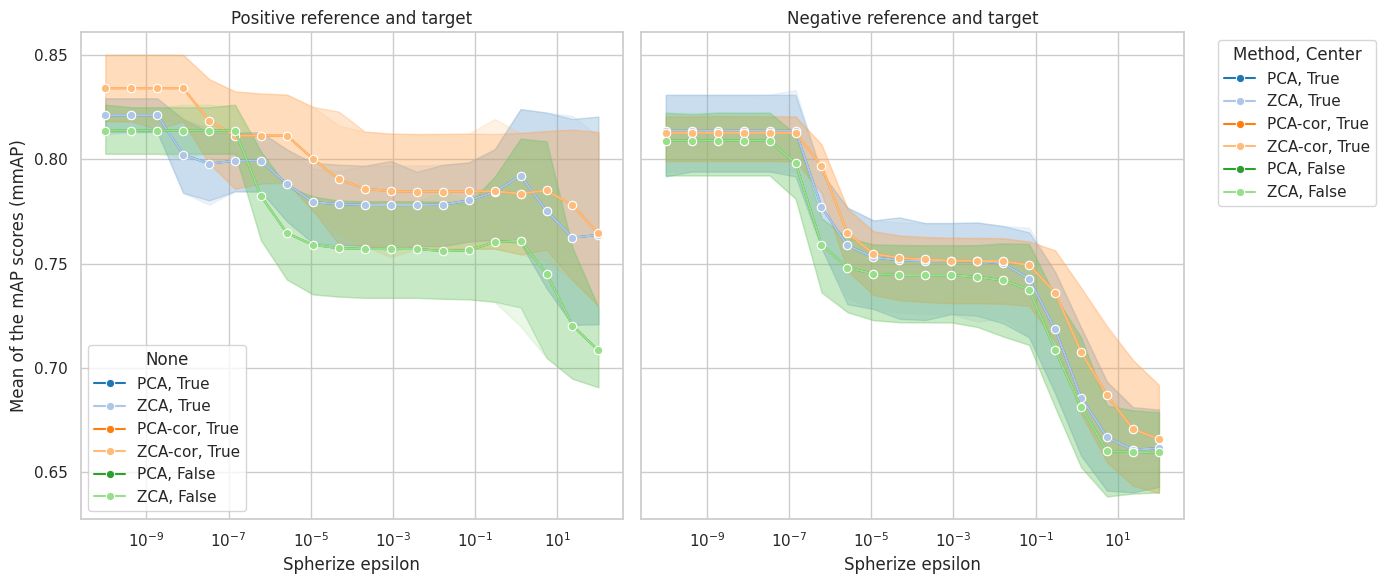

In [8]:
# set plot style
sns.set(style="whitegrid")

# create the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# define colors based on method and center
hue_order = mmAP_concat_df.groupby(["spherize_method", "spherize_center"]).ngroup()
palette = "tab20"

# line plot that contains mmAP scores when comparing both positives reference and target 
sns.lineplot(
    data=mmAP_concat_df[
        mmAP_concat_df["Metadata_reference_control_type"] == "positive"
    ],
    x="spherize_epsilon",
    y="mmAP",
    hue=mmAP_concat_df[
        mmAP_concat_df["Metadata_reference_control_type"] == "positive"
    ].apply(lambda row: f"{row['spherize_method']}, {row['spherize_center']}", axis=1),
    ax=axes[0],
    marker="o",
    palette=palette,
)
axes[0].set_title("Positive reference and target")
axes[0].set_xscale("log")
axes[0].set_xlabel("Spherize epsilon")
axes[0].set_ylabel("Mean of the mAP scores (mmAP)")

# line plot that contains mmAP scores when comparing both negative reference and target 
sns.lineplot(
    data=mmAP_concat_df[
        mmAP_concat_df["Metadata_reference_control_type"] == "negative"
    ],
    x="spherize_epsilon",
    y="mmAP",
    hue=mmAP_concat_df[
        mmAP_concat_df["Metadata_reference_control_type"] == "negative"
    ].apply(lambda row: f"{row['spherize_method']}, {row['spherize_center']}", axis=1),
    ax=axes[1],
    marker="o",
    palette=palette,
)
axes[1].set_title("Negative reference and target")
axes[1].set_xscale("log")
axes[1].set_xlabel("Spherize epsilon")
axes[1].set_ylabel("Mean of the mAP scores (mmAP)")

# Adjust legend placement
axes[1].legend(title="Method, Center", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.tight_layout()
plt.show()


In [9]:
## PCA plots 



Text(0.5, 1.0, 'PCA plot of aggregated profiles')

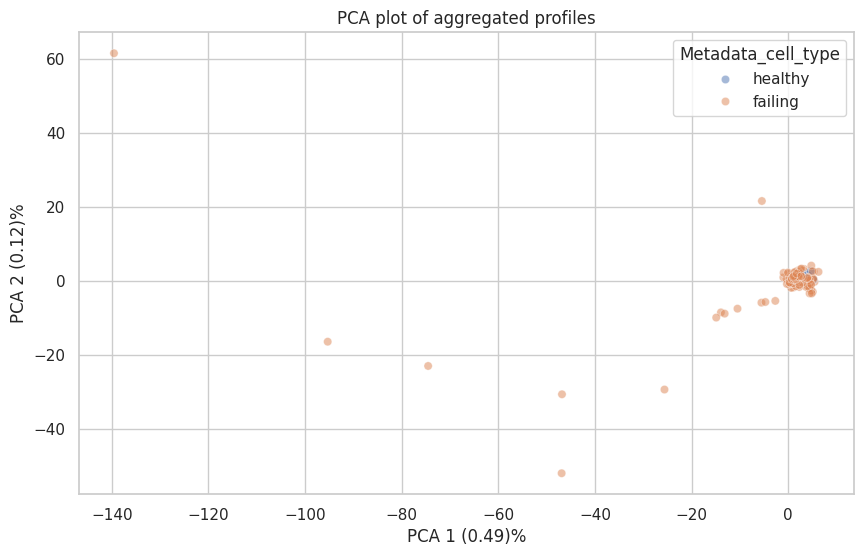

In [20]:
# set PCA parameters
n_components = 2
random_state = 0
agg_norm_profile = loaded_profiles["batch_1"]
pca = PCA(n_components=n_components, random_state=random_state)
pca_results = pca.fit_transform(agg_norm_profile[feat_cols])

# setting fig size
plt.figure(figsize=(10, 6))
# plot PCA results
sns.scatterplot(
    x=pca_results[:, 0],
    y=pca_results[:, 1],
    hue=loaded_profiles["batch_1"]["Metadata_cell_type"],
    # palette="",
    alpha=0.5,
)

# add axis labels
plt.xlabel(f"PCA 1 ({pca.explained_variance_ratio_[0]:.2f})%")
plt.ylabel(f"PCA 2 ({pca.explained_variance_ratio_[1]:.2f})%")
plt.title("PCA plot of aggregated profiles")

In [11]:
pc_df = pd.DataFrame(pca_results, columns=[f"PC{i}" for i in range(1, n_components + 1)])
pc_df["cell_type"] = agg_norm_profile["Metadata_cell_type"].values
pc_df

,PC1,PC2,cell_type
0,3.284516,1.175778,healthy
1,1.905740,-0.034605,failing
2,1.021296,-1.818749,failing
3,2.927333,1.226281,healthy
4,4.663055,-0.551800,failing
...,...,...,...
215,2.748681,3.307496,failing
216,1.140408,1.372776,failing
217,1.036567,1.090772,failing
218,1.758504,1.961382,failing


Text(0, 0.5, 'PCA 2 (0.08)%')

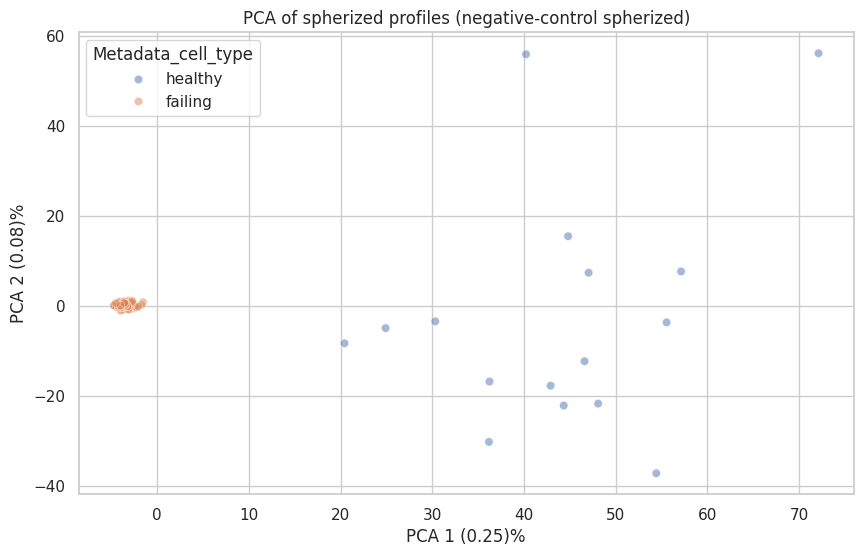

In [ ]:
# spherizing profilez
spherized_profile = normalize(
    profiles=agg_norm_profile,
    features=feat_cols,
    meta_features=meta_cols,
    samples= "Metadata_control_type == 'negative'",
    method="spherize",
    spherize_center=True,
    spherize_method="ZCA",
    # spherize_epsilon=0.1,
)

# generate 
dmso_meta = [
    cols for cols in spherized_profile.columns.tolist() if cols.startswith("Metadata_")
]
dmso_feats = [
    cols
    for cols in spherized_profile.columns.tolist()
    if not cols.startswith("Metadata_")
]

# create PC components with spherized profiles
pca_spherized = PCA(n_components=n_components, random_state=random_state)
pca_spherized_results = pca_spherized.fit_transform(spherized_profile[dmso_feats])

# now plot it into a scatter plot using seaborn 
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_spherized_results[:, 0],
    y=pca_spherized_results[:, 1],
    hue=spherized_profile["Metadata_cell_type"],
    alpha=0.5,
)

# now adding titles 
plt.title("PCA of spherized profiles (negative-control spherized)")
plt.xlabel(f"PCA 1 ({pca_spherized.explained_variance_ratio_[0]:.2f})")
plt.ylabel(f"PCA 2 ({pca_spherized.explained_variance_ratio_[1]:.2f})")

Text(0, 0.5, 'PCA 2 (0.12)%')

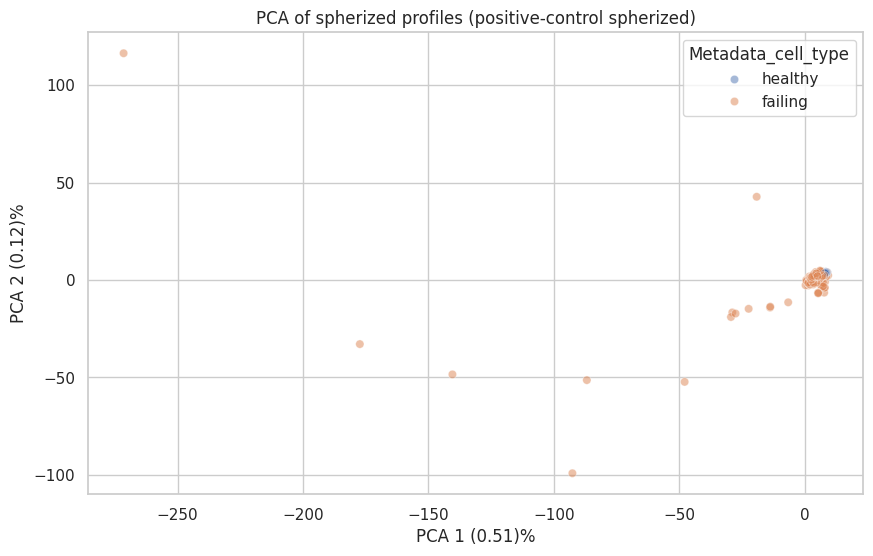

In [26]:
# now lets apply spherization to the positive control 
spherized_profile = normalize(
    profiles=agg_norm_profile,
    features=feat_cols,
    meta_features=meta_cols,
    samples= "Metadata_control_type == 'positive'",
    method="spherize",
    spherize_center=True,
    spherize_method="ZCA",
    # spherize_epsilon=0.1,
)

# separate metadata and feature columns
dmso_meta = [
    cols for cols in spherized_profile.columns.tolist() if cols.startswith("Metadata_")
]
dmso_feats = [
    cols
    for cols in spherized_profile.columns.tolist()
    if not cols.startswith("Metadata_")
]

# create PC components with spherized profiles
pca_spherized = PCA(n_components=n_components, random_state=random_state)
pca_spherized_results = pca_spherized.fit_transform(spherized_profile[dmso_feats])

# now plot it into a scatter plot using seaborn
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=pca_spherized_results[:, 0],
    y=pca_spherized_results[:, 1],
    hue=spherized_profile["Metadata_cell_type"],
    alpha=0.5,
)

# now adding titles
plt.title("PCA of spherized profiles (positive-control spherized)")
plt.xlabel(f"PCA 1 ({pca_spherized.explained_variance_ratio_[0]:.2f})%")
plt.ylabel(f"PCA 2 ({pca_spherized.explained_variance_ratio_[1]:.2f})%")